In [1]:
# Download GloVe embeddings
!  gdown --id 1DKTVDj3U3dT93EtjrhPNS5kA6mF2t0D0
# Downloadd dataset
!  gdown --id 1R7bnlwW1xUHR5_L6K1ejhYKJlOQoYFSG

Downloading...
From: https://drive.google.com/uc?id=1DKTVDj3U3dT93EtjrhPNS5kA6mF2t0D0
To: /content/glove.6B.50d.txt
171MB [00:01, 96.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1R7bnlwW1xUHR5_L6K1ejhYKJlOQoYFSG
To: /content/COQB-19_crowdsourced_06202020.csv
100% 907k/907k [00:00<00:00, 14.3MB/s]


In [2]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
cols = ['ID(original)', 'ID' , 'Q' , 'A']
data = pd.read_csv('COQB-19_crowdsourced_06202020.csv', sep=',', names=cols, header=None, encoding='latin-1',skiprows=1)
data = data.dropna()
Questions = data['Q']
ID= data['ID'].tolist()
corpus = Questions.tolist()
Answers =data['A'].tolist()

In [4]:
lemmatizer = WordNetLemmatizer()
def stemSentence(sentence):
    token_words= word_tokenize(sentence)
    lematized_tokens = [lemmatizer.lemmatize(w) for w in token_words]
    return "  ".join(lematized_tokens)

In [30]:
stemmed_corpus = []
for i in range(len(corpus)):
  stemmed_corpus.append((i,stemSentence(corpus[i])))

In [6]:
def load_glove_model(glove_file):
    model = {}
    f = open(glove_file + ".txt", 'r', encoding='utf-8')
    for line in f:
        split_line = line.split()
        word = split_line[0]
        embedding = np.array([float(val) for val in split_line[1:]])
        model[word] = embedding
    return model

In [10]:
glove = load_glove_model("glove.6B.50d")
glove_dim = 50

In [22]:
def encode_sentence_as_vector(sentence, model):
  sentence_tokens = sentence.split()
  sentence_array = np.zeros(shape=(len(sentence_tokens), glove_dim))
  for i,w in enumerate(sentence_tokens):
    if w in model:
      sentence_array[i,:] = model[w]
  sentence_vec = np.mean(sentence_array, axis=0)
  return sentence_vec.reshape((1,-1))

In [32]:
X = []
Q = np.zeros((len(stemmed_corpus),glove_dim), dtype=np.float64)
for i in range(len(stemmed_corpus)):
  Q[i,:] = encode_sentence_as_vector(stemmed_corpus[i][1], glove)
Q

array([[ 0.56617667, -0.00320167,  0.08669417, ..., -0.07178177,
         0.18564167,  0.19455183],
       [-0.14798833,  0.06607333,  0.33847417, ..., -0.29220917,
         0.11753167,  0.527162  ],
       [ 0.23657143,  0.27476771,  0.16698929, ...,  0.22218429,
         0.16893429,  0.44120557],
       ...,
       [ 0.0275    ,  0.126692  ,  0.069227  , ..., -0.05239   ,
        -0.004068  ,  0.412414  ],
       [ 0.35022414,  0.31170257,  0.06955357, ...,  0.19326786,
         0.10614154,  0.19616571],
       [ 0.40309833,  0.22314667,  0.26248417, ..., -0.12156383,
        -0.10294333,  0.38326833]])

In [13]:
def answer_question(question, corpus_X):
  """  returns (top_idx,  top_idx_score, all_scores)
  top_idx: index of most similar question
  top_idx_score:  score of most similar question.
  all_scores: scores of all candidates.
  """
  lematized_question = stemSentence(question)
  question_x = encode_sentence_as_vector(lematized_question, glove)
  sim_scores = cosine_similarity(question_x,  corpus_X).ravel()
  top_idx = np.argmax(sim_scores)
  return top_idx, sim_scores[top_idx], sim_scores


In [14]:
test_question = 'does covid affect young people more?'
answer_idx, answer_score,_ = answer_question(test_question, Q)
print('Similarity score = ', answer_score)
print('Most similiar question: ', corpus[stemmed_corpus[answer_idx][0]])
print('suggested answer: ', Answers[stemmed_corpus[answer_idx][0]])

Similarity score =  0.9772328324880535
Most similiar question:  Do young people die from COVID-19?
suggested answer:  COVID-19 is an equal opportunity virus. The mortality rate is varied across some demographic segments, but it impacts all groups of people.


In [15]:
def compute_precision_recall_at_threshold(corpus, ids, corpus_X, threshold):
  precision_list = []
  recall_list = []
  for i,test_doc in enumerate(corpus):
    if i%20 != 0:
    # this is done only to speed calculations a bit. we compute metrics based
    # on 5% of data.
      continue
    _,_,  scores = answer_question(test_doc, corpus_X)
    preds = scores >= threshold
    labels = np.array([a_id==ids[i] for a_id in ids])
    precision_list.append(precision_score(labels, preds))
    recall_list.append(recall_score(labels, preds))
  return np.mean(precision_list),  np.mean(recall_list)

In [16]:
probability_thresholds = np.linspace(0,1, num=50)
prec_list =[]
rec_list =[]
for threshold in probability_thresholds:
  cur_prec, cur_rec = compute_precision_recall_at_threshold(corpus, ID,  Q,threshold)
  prec_list.append(cur_prec)
  rec_list.append(cur_rec)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

Text(0, 0.5, 'precision')

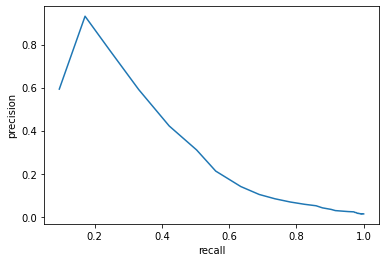

In [17]:
plt.plot(rec_list,  prec_list)
plt.xlabel('recall')
plt.ylabel('precision')

## compute recall at 5.

In [18]:
def compute_prec_recall_at_k(corpus, ids, corpus_X, k=5):
  prec_at_k_list = []
  recall_at_k_list = []
  for i,test_doc in enumerate(corpus):
    if i%20 != 0:
    # this is done only to speed calculations a bit. we compute metrics based
    # on 5% of data.
      continue
    _,_,  scores = answer_question(test_doc, corpus_X)
    top_k_idx = np.argsort(scores)[::-1][:k]
    top_k_labels = [ids[idx] for idx in top_k_idx]
    num_true_labels = np.sum([a_id==ids[i] for a_id in ids])
    num_true_in_top_k = np.sum([a_id==ids[i] for a_id in top_k_labels])
    cur_prec_at_k = num_true_in_top_k/k
    cur_recall_at_k = num_true_in_top_k / num_true_labels
    recall_at_k_list.append(cur_recall_at_k)
    prec_at_k_list.append(cur_prec_at_k)
  return np.mean(prec_at_k_list), np.mean(recall_at_k_list)

In [19]:
print("Prec, Recall at 1 : ",  compute_prec_recall_at_k(corpus, ID,Q, 1))

Prec, Recall at 1 :  (0.9401709401709402, 0.11207079724421402)


In [20]:
print("Prec, Recall at 5 : ",  compute_prec_recall_at_k(corpus, ID,Q, 5))

Prec, Recall at 5 :  (0.6051282051282053, 0.21838322356355344)


In [21]:
print("Prec,Recall at 10 : ",  compute_prec_recall_at_k(corpus, ID,Q, 10))

Prec,Recall at 10 :  (0.4871794871794871, 0.2939409663189171)
